In [1]:
library(coda)

# Exercise 1: Sampling Gaussian Mixture
Let $g(x, \mu, \sigma)$ be the un-normalized distribution of weighted mixture of two Gaussian distributions 
$$g(\theta|x) = \sum_{i=1}^2\ \phi_i N(\mu_i, \sigma_i)$$ where
- $\phi_0 = 0.6$ and $\phi_1 = 0.4$
- $\mu = \{-3,3\}$ and $\sigma = \{1,1\}$

Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm, usings
a Norm (0, 1) as random-walk candidate density

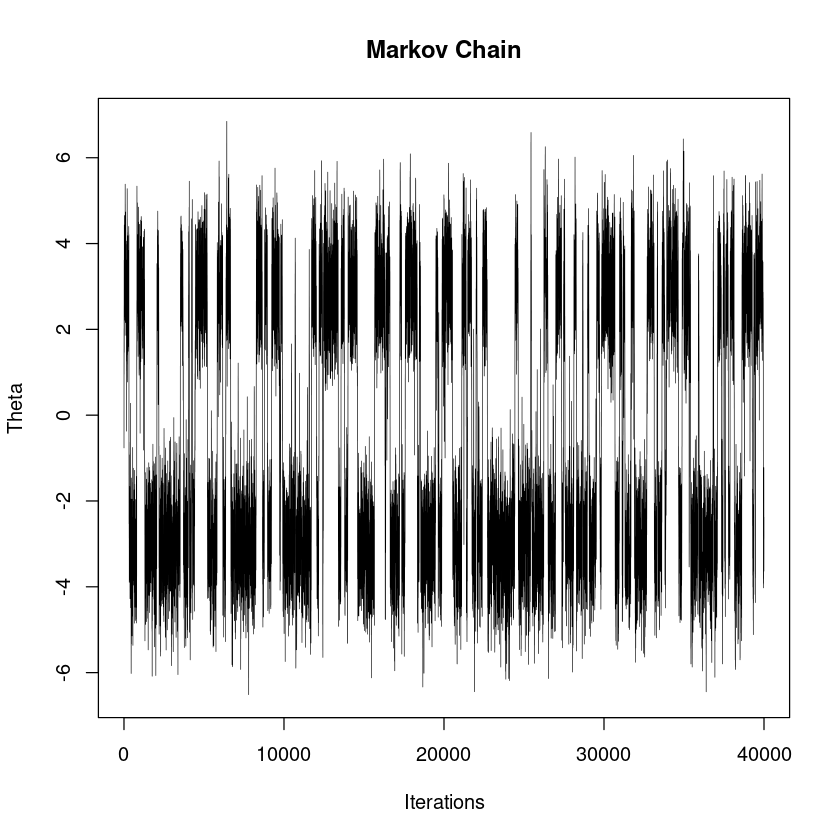

In [2]:
phi <- c(0.6, 0.4)
mu <- c(-3, 3)
sigma <- c(1, 1)

g <- function(theta) {
    sum(phi * dnorm(theta, mu, sigma))
}

n_steps <- 40000
theta_current <- 0
list_theta <- c()
for (i in 1:n_steps) {
    theta_hat <- theta_current + rnorm(1)
    alpha <- min(1, g(theta_hat)/g(theta_current))
    if (runif(1) < alpha) {
        theta_current <- theta_hat
    }
    list_theta <- c(list_theta, theta_current)
}
plot(list_theta, lwd=0.5, main="Markov Chain",
     type="l", xlab="Iterations", ylab="Theta"
)

Plot the sampled distribution

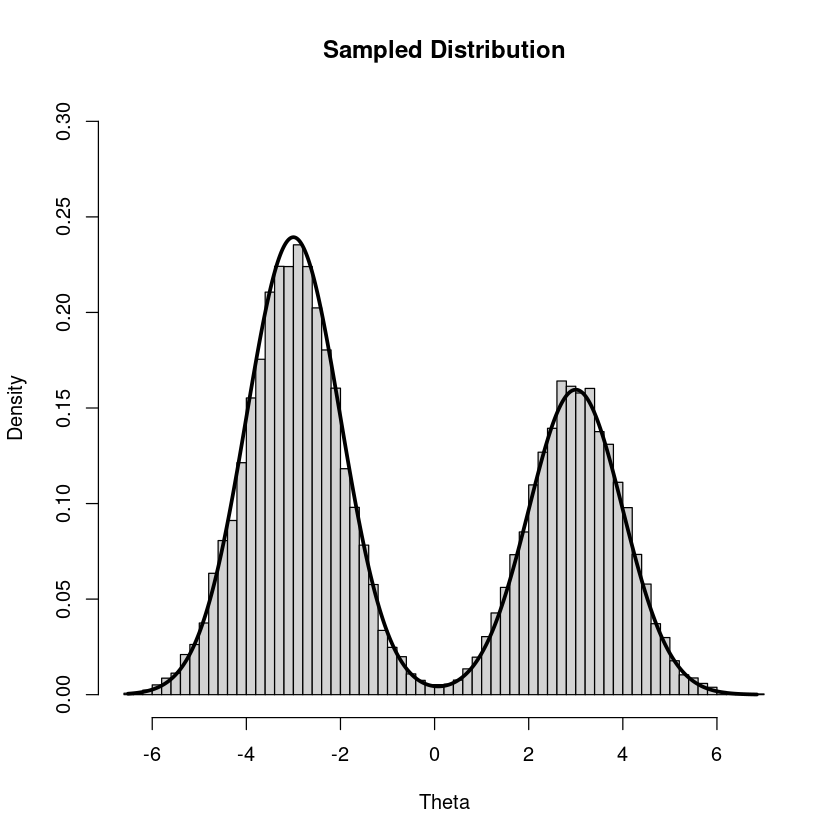

In [3]:
hist(list_theta, breaks=length(list_theta)^.4, 
     freq=FALSE, ylim=c(0,0.3),
     xlab="Theta", main="Sampled Distribution"
)
theta_range <- seq(min(list_theta), max(list_theta), length.out=1000)
y <- c()
for (theta in theta_range) {
    y <- c(y, g(theta))
}
lines(theta_range, y, lwd=3)

Evaluate the mean and the variance

In [4]:
theta_mean <- mean(list_theta)
theta_var <- var(list_theta)
cat("Mean:", theta_mean, "\nVar:", theta_var)

Mean: -0.5034015 
Var: 9.818394

Analyze the chain with the CODA package and plot the chain autocorrelation

Effective size: 168.2935

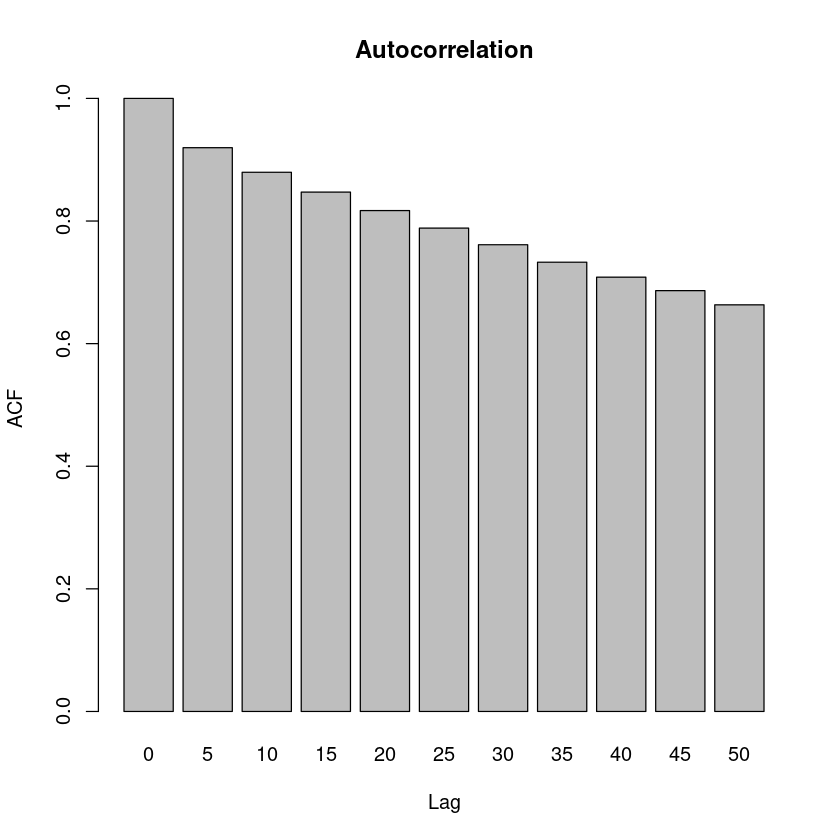

In [5]:
chain <- mcmc(list_theta)

plot_acf <- function(chain) {
    lags <- seq(0,50,5)
    acf <- autocorr(chain, lags=lags)
    barplot(as.numeric(acf),
            xlab = "Lag", ylab = "ACF",
            main = "Autocorrelation",
            names.arg = lags
    )
}

plot_acf(chain)
eff_size1 <- effectiveSize(chain)
cat("Effective size:", eff_size1)

Try different burn-in cycles and thinning, plot the related posterior distribution and the chain autocorrelation function. What are the best parameters?


Effective size for 1000 burn-in and
	- thinning by 5: 150.644
	- thinning by 10: 153.8365
	- thinning by 15: 144.1356
	- thinning by 20: 144.0968

Effective size for 2000 burn-in and
	- thinning by 5: 148.3698
	- thinning by 10: 151.8011
	- thinning by 15: 151.8536
	- thinning by 20: 142.131

Effective size for 3000 burn-in and
	- thinning by 5: 144.769
	- thinning by 10: 147.6387
	- thinning by 15: 133.4512
	- thinning by 20: 139.7096

Effective size for 4000 burn-in and
	- thinning by 5: 141.7412
	- thinning by 10: 138.1157
	- thinning by 15: 135.9839
	- thinning by 20: 137.4132

Best parameters: 4000 burn-in, thinning by 20

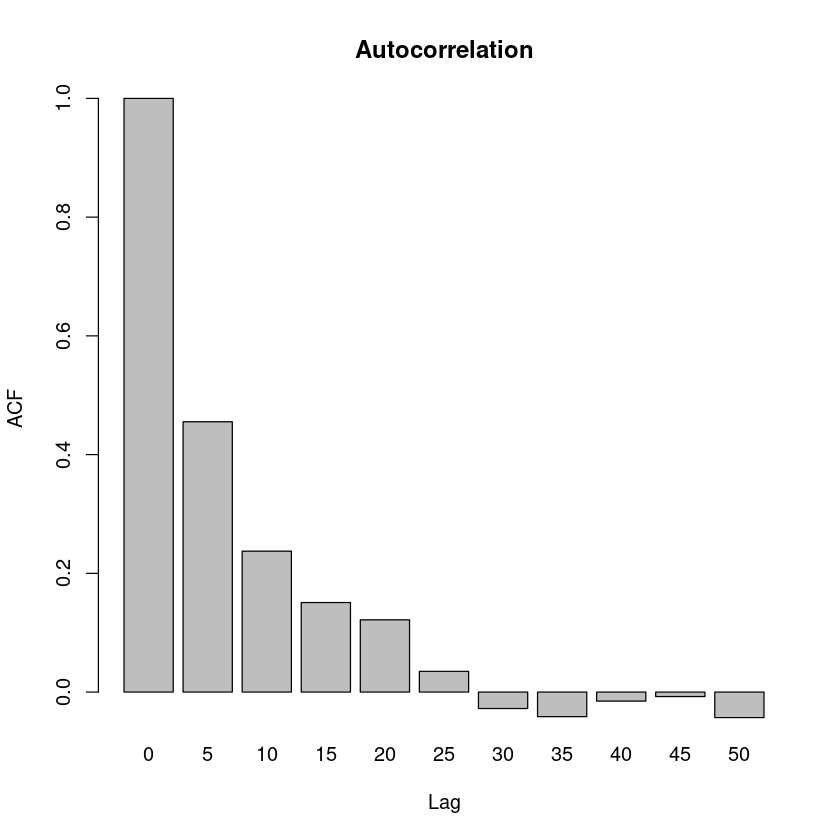

In [6]:
burnin_values <- c(1000, 2000, 3000, 4000)
thinning_values <- c(5, 10, 15, 20)

best_rate <- eff_size1 / n_steps
best_params <- c("no burn-in,", "thinning by 0")
best_chain <- chain
for (b in burnin_values) {
    cat("\nEffective size for ", b, " burn-in and\n", sep="")
    for (t in thinning_values) {
        burnin_ix <- b:length(list_theta)
        thinning_ix <- seq(1, length(burnin_ix), by = t)
        
        new_list_params <- list_theta[burnin_ix][thinning_ix]
        new_chain <- mcmc(new_list_params)
        eff_size <- effectiveSize(new_chain)

        cat("\t- thinning by ", t, ": ", eff_size, 
            "\n", sep="")
        
        current_rate <- eff_size / length(new_list_params)
        if (current_rate > best_rate) {
            best_rate <- current_rate
            best_params <- c(paste(b, "burn-in, "), 
                             paste("thinning by", t))
            best_chain <- new_chain
        }
        
    }
}

cat("\nBest parameters: ", best_params, sep="")
plot_acf(best_chain)

# Exercise 2: Gaussian model
Let
$$\vec{x} = \{ 13.427, 8.588, 10.908, 11.582, 11.011, 9.735, 13.779, 9.763 \}$$
be $n = 8$ observed data from a Gaussian distribution with unknown mean $m$ and variance $s^2$.

Assuming a uniform prior distributions for the parameters,
- ```m ~ dunif(-10,30)```
- ```s ~ dnorm(0,50)```

build a simple JAGS model and run a Markov Chain Monte Carlo to obtain the posterior distribution of the mean and variance.

Compute the posterior distribution for $m/s$

# Exercise 3 : Power Law fitting
Using R, generate 100 synthetic data from power law distribution
$$p(x | \alpha, x_{min}) = \frac{\alpha-1}{x_{min}} \left( \frac{x}{x_{min}} \right)^{-\alpha}, \quad x \ge x_{min}$$
with fixed $x_{min} = 10$ and power law exponent $\alpha = 2.5$

Assuming $x_{min}$ fixed and $\alpha$ unknown, build JAGS models using the priors
- ```alpha ∼ dunif(1.01, 10)```
- ```alpha ∼ dnorm(2.5, 100)```

Run MCMC to get the posterior distribution. Evaluate the mean, the most probable value, the credibility interval at 95% level.

Compare the Bayesian estimate for $\alpha$ with the one achieved in frequentist setting.